In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

#'bs140513_032310.csv', 'bsNET140513_032310.csv'

cols = ['customer','merchant', 'category', 'amount']
df = pd.read_csv('bs140513_032310.csv')[cols + ['fraud']]
print(df.head(), df.shape)

        customer       merchant             category  amount  fraud
0  'C1093826151'   'M348934600'  'es_transportation'    4.55      0
1   'C352968107'   'M348934600'  'es_transportation'   39.68      0
2  'C2054744914'  'M1823072687'  'es_transportation'   26.89      0
3  'C1760612790'   'M348934600'  'es_transportation'   17.25      0
4   'C757503768'   'M348934600'  'es_transportation'   35.72      0 (594643, 5)


In [17]:
df.sort_values(by='amount')

,customer,merchant,category,amount,fraud
193548,'C1659350842','M1823072687','es_transportation',0.00,0
449213,'C1372042334','M348934600','es_transportation',0.00,0
539403,'C1964602402','M348934600','es_transportation',0.00,0
480759,'C808326652','M1823072687','es_transportation',0.00,0
474952,'C521129957','M1823072687','es_transportation',0.00,0
...,...,...,...,...,...
329533,'C430880678','M2080407379','es_travel',7403.44,1
6710,'C375144053','M732195782','es_travel',7432.48,1
383889,'C1007572087','M732195782','es_travel',7635.41,1
135692,'C806399525','M732195782','es_travel',7665.56,1


In [18]:
# I don't think zeroes should be here, so let's remove them
df = df[df['amount'] > 0]

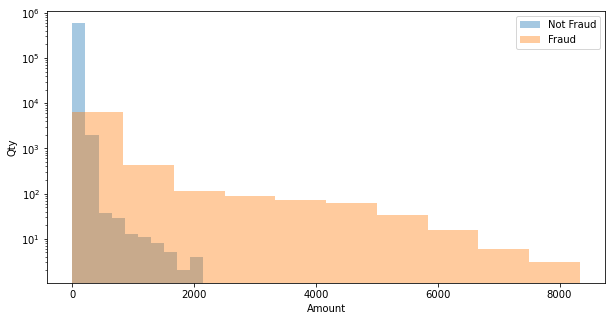

In [21]:
# Let's take a look at the data
plt.figure(figsize=(10,5))

sns.distplot(df[df['fraud'] == 0]['amount'], bins=10, kde=False)
sns.distplot(df[df['fraud'] == 1]['amount'], bins=10, kde=False)
plt.legend(labels=['Not Fraud','Fraud'])
plt.yscale('log')
plt.ylabel('Qty')
plt.xlabel('Amount')
plt.show()

In [22]:
# Theres categorical data, we must convert them
print('Theres {} customers, {} merchants and {} categories.'.format(
    len(Counter(df['customer'])),
    len(Counter(df['merchant'])),
    len(Counter(df['category']))))

Theres 4112 customers, 50 merchants and 15 categories.


In [23]:
# A 594643 x (4112 + 50 + 15) shaped matrix is too much, so let's deal with merchants and categories first
temp = pd.concat([pd.get_dummies(df['merchant'], drop_first=True), pd.get_dummies(df['category'], drop_first=True)], axis=1)
print(temp.shape)

(594591, 63)


In [24]:
temp.head()

,'M117188757','M1198415165','M1294758098','M1313686961','M1352454843','M1353266412','M1400236507','M1416436880','M151143676','M1535107174',...,'es_home','es_hotelservices','es_hyper','es_leisure','es_otherservices','es_sportsandtoys','es_tech','es_transportation','es_travel','es_wellnessandbeauty'
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# Since there's 4k categories in customers let's try something different, the customer ID will be now the count 
# of times it apperas on the dataset
c = Counter(df['customer'])
df['customer'] = df['customer'].map(c)
df.head()

,customer,merchant,category,amount,fraud
0,167,'M348934600','es_transportation',4.55,0
1,169,'M348934600','es_transportation',39.68,0
2,65,'M1823072687','es_transportation',26.89,0
3,171,'M348934600','es_transportation',17.25,0
4,145,'M348934600','es_transportation',35.72,0


In [26]:
# Train test splitting
X = pd.concat([df['customer'], temp , df['amount']], axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(398375, 65) (196216, 65) (398375,) (196216,)


In [27]:
# I did a gridsearch, and it took a good waiting since my computer is not that strong, so I'll just place the final values 
# instead

#lr = [l/100 for l in list(range(10, 31, 1))] 
#print(lr)

#parameters = {
#    'max_depth': range (4, 8, 1),
#    'n_estimators': range(60, 221, 40),
#    'learning_rate': lr,
#}

#estimator = xgb.XGBClassifier(
#    objective= 'binary:logistic',
#    seed=42,
#    nthread=-1,
#)

#grid_search = GridSearchCV(
#    estimator=estimator,
#    param_grid=parameters,
#    scoring = 'precision',
#    n_jobs = -1,
#    cv = 2,
#    verbose=True
#)

#grid_search.fit(X_train, y_train)

In [28]:
#clf = grid_search.best_estimator_
#print(clf)

In [29]:
# Here's the classifier using the parameters obtained using grid search
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=60, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [30]:
# Adjusting the cutoff increases precision and decreases recall, for now I'll leave at 0.6 
cutoff = 0.6

print('--------------------------Train--------------------------')

y_p = clf.predict_proba(X_train)[:,1]

y_pred = y_p > cutoff

tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

results = pd.DataFrame([[tn, fp], [fn, tp]], columns = ['Predicted Negative', 'Predicted Positive']) 
results.index = ['Actual Negative', 'Actual Positive']
print(results)

print('---------------------------------------------------------')

accuracy = (tn + tp) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall_sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

results = pd.DataFrame([roc_auc_score(y_train, y_p), accuracy, precision, recall_sensitivity, specificity], 
                       columns = ['Values']) 

results.index = ['ROC AUC Score', 'Accuracy', 'Precision', 'Recall/Sensitivity', 'Specificity']
print(results)
print('\n')

print('--------------------------Test--------------------------')

y_p = clf.predict_proba(X_test)[:,1]

y_pred = y_p > cutoff

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

results = pd.DataFrame([[tn, fp], [fn, tp]], columns = ['Predicted Negative', 'Predicted Positive']) 
results.index = ['Actual Negative', 'Actual Positive']
print(results)

print('--------------------------------------------------------')

accuracy = (tn + tp) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall_sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

results = pd.DataFrame([roc_auc_score(y_test, y_p), accuracy, precision, recall_sensitivity, specificity], 
                       columns = ['Values']) 

results.index = ['ROC AUC Score', 'Accuracy', 'Precision', 'Recall/Sensitivity', 'Specificity']
print(results)
print('\n')

print('--------------------------Total--------------------------')

y_p = clf.predict_proba(X)[:,1]

y_pred = y_p > cutoff

tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

results = pd.DataFrame([[tn, fp], [fn, tp]], columns = ['Predicted Negative', 'Predicted Positive']) 
results.index = ['Actual Negative', 'Actual Positive']
print(results)

print('----------------------------------------------------------')

accuracy = (tn + tp) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall_sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

results = pd.DataFrame([roc_auc_score(y, y_p), accuracy, precision, recall_sensitivity, specificity], 
                       columns = ['Values']) 

results.index = ['ROC AUC Score', 'Accuracy', 'Precision', 'Recall/Sensitivity', 'Specificity']
print(results)

--------------------------Train--------------------------
                 Predicted Negative  Predicted Positive
Actual Negative              393418                 135
Actual Positive                1318                3504
---------------------------------------------------------
                      Values
ROC AUC Score       0.998115
Accuracy            0.996353
Precision           0.962902
Recall/Sensitivity  0.726669
Specificity         0.999657


--------------------------Test--------------------------
                 Predicted Negative  Predicted Positive
Actual Negative              193749                  89
Actual Positive                 673                1705
--------------------------------------------------------
                      Values
ROC AUC Score       0.998016
Accuracy            0.996117
Precision           0.950390
Recall/Sensitivity  0.716989
Specificity         0.999541


--------------------------Total--------------------------
                 Predict